### Import Libraries

In [1]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
import pickle
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os, sys
import track_points_helper
from skimage.feature import peak_local_max
from skimage.transform import rescale
# Adjust the path to your Python version and where the library has been installed
# sys.path.append('/zhome/42/8/213460/.local/lib/python3.11/site-packages')
from natsort import natsorted


### Help functions

In [2]:
def load_or_create_stack(folder_path, save_path):
    """Load stack from saved TIFF file or create it from individual TIF files."""
    
    # Update the file extension to .tif
    save_path = save_path.replace('.npy', '.tif')
    
    # Check if saved file already exists
    if os.path.exists(save_path):
        print(f"Loading pre-assembled data from {save_path}")
        return tiff.imread(save_path)
    
    # If not, create the stack from individual files
    print(f"Assembling data from {folder_path}")
    file_names = natsorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])
    stack = [tiff.imread(os.path.join(folder_path, f)) for f in file_names]
    assembled_stack = np.stack(stack)

    # Save the assembled stack as TIFF
    print(f"Saving assembled data to {save_path}")
    tiff.imwrite(save_path, assembled_stack)
    print(f"Saved assembled data to {save_path}")
    
    return assembled_stack

def normalize_to_uint8(image):
    """Memory-efficient normalization to uint8 range"""
    # Get min and max
    min_val = image.min()
    max_val = image.max()
    
    if max_val == min_val:
        return np.zeros_like(image, dtype=np.uint8)
    
    # Create output array directly as uint8
    output = np.empty(image.shape, dtype=np.uint8)
    
    # Normalize in-place with dtype control
    # Use float32 instead of default float64
    scale = 255.0 / (max_val - min_val)
    np.multiply(image - min_val, scale, out=output, casting='unsafe')
    
    return output


def downscale_volume(volume, scale_factor):
    """Downscale a 3D volume by the given factor.
    
    Parameters:
    -----------
    volume : 3D numpy array
        The input volume to downscale
    scale_factor : float or tuple
        Scale factor for (x,y,z) dimensions. If float, same factor is used for all dimensions.
        
    Returns:
    --------
    downscaled_volume : 3D numpy array
        The downscaled volume
    """
    if isinstance(scale_factor, (int, float)):
        # Same scale factor for all dimensions
        scale_factor = (scale_factor, scale_factor, scale_factor)
    
    # Handle z-dimension separately (slice by slice approach)
    z_indices = np.arange(0, volume.shape[0], scale_factor[2]).astype(int)
    
    # First rescale a sample slice to get exact output dimensions
    sample_rescaled = rescale(volume[z_indices[0]], 
                             (1/scale_factor[0], 1/scale_factor[1]), 
                             preserve_range=True,
                             anti_aliasing=True)
    
    # Create output array with exact dimensions from sample
    downscaled_volume = np.zeros((len(z_indices), 
                                  sample_rescaled.shape[0], 
                                  sample_rescaled.shape[1]), 
                                 dtype=volume.dtype)
    
    # Store the already processed first slice
    downscaled_volume[0] = sample_rescaled.astype(volume.dtype)
    
    # Process remaining slices
    for i, slice_idx in enumerate(z_indices[1:], start=1):
        downscaled_volume[i] = rescale(volume[slice_idx], 
                                      (1/scale_factor[0], 1/scale_factor[1]), 
                                      preserve_range=True,
                                      anti_aliasing=True).astype(volume.dtype)
    
    return downscaled_volume

### Data

##### Defining paths and loading data

In [3]:
# Paths to extracted slices
path_UD = os.path.join(os.getcwd(), 'data/UD-01_FoV_2_B2_recon_2Dtif')
path_Mock = os.path.join(os.getcwd(), 'data/Mock-01_FoV_2_B2_recon_2Dtif')

# Paths to save the assembled stacks
save_path_UD = os.path.join(os.getcwd(), 'data/assembled_3D_tif_data_UD.tif')
save_path_Mock = os.path.join(os.getcwd(), 'data/assembled_3D_tif_data_Mock.tif')

# Load stacks
tif_data_UD = load_or_create_stack(path_UD, save_path_UD)
tif_data_Mock = load_or_create_stack(path_Mock, save_path_Mock)

Loading pre-assembled data from /dtu/3d-imaging-center/courses/02509/groups/members/Lukas_s243430/FiberDetection/data/assembled_3D_tif_data_UD.tif
Loading pre-assembled data from /dtu/3d-imaging-center/courses/02509/groups/members/Lukas_s243430/FiberDetection/data/assembled_3D_tif_data_Mock.tif


##### Data investigation

Loaded UD stack shape: (999, 1013, 988)
Loaded Mock stack shape: (999, 1013, 988)
Preprocessed UD stack shape: (666, 675, 659)
Preprocessed Mock stack shape: (666, 675, 659)


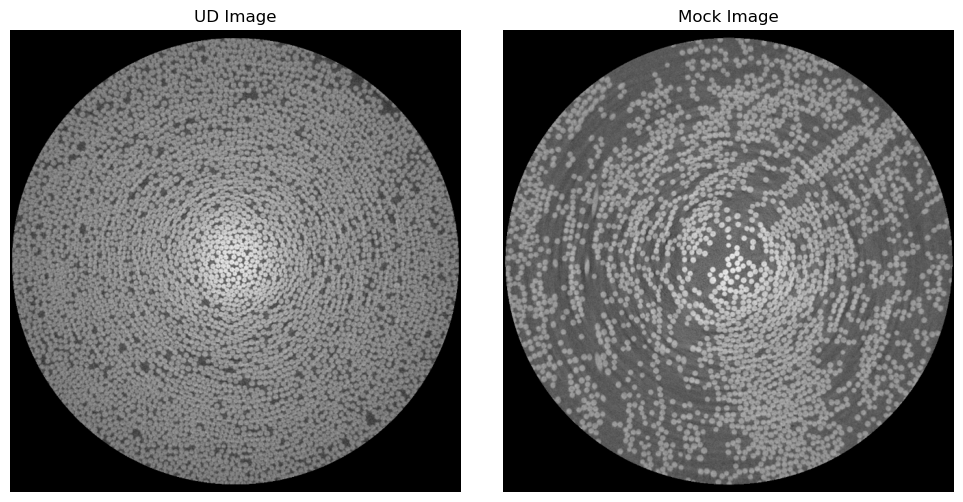

In [4]:
# Check shapes
print("Loaded UD stack shape:", tif_data_UD.shape)
print("Loaded Mock stack shape:", tif_data_Mock.shape)

use_normalization = True
if use_normalization:
    # Create normalized versions
    tif_data_UD = normalize_to_uint8(tif_data_UD)
    tif_data_Mock = normalize_to_uint8(tif_data_Mock)

downscale = True
if downscale:   
    # Define downscaling factor
    scale_factor = 1.5  # Try 2x downscaling (4x is to much, image is to blurry to actually detect fiber centers)

    # Downscale both datasets
    tif_data_UD = downscale_volume(tif_data_UD, scale_factor)
    tif_data_Mock = downscale_volume(tif_data_Mock, scale_factor)

# Check shapes
print("Preprocessed UD stack shape:", tif_data_UD.shape)
print("Preprocessed Mock stack shape:", tif_data_Mock.shape)

# Visualize first slice
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tif_data_UD[0], cmap='gray')
plt.title('UD Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(tif_data_Mock[0], cmap='gray')
plt.title('Mock Image')
plt.axis('off')
plt.tight_layout()
plt.show()

##### Data visualizations

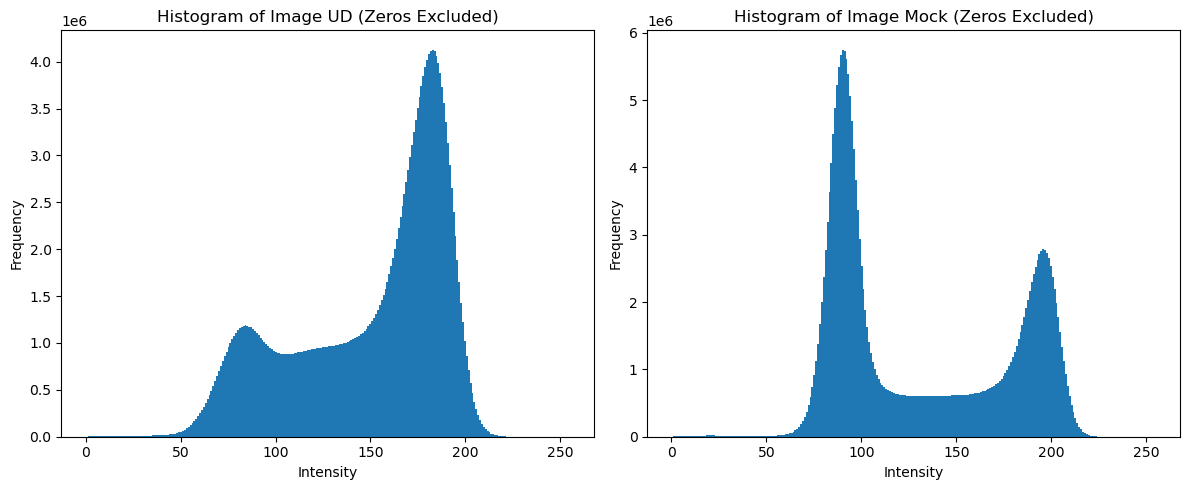

UD data: 223323899 non-zero pixels (75.38% of total)
Mock data: 223529299 non-zero pixels (75.45% of total)


In [5]:
# Create histograms excluding zeros
plt.figure(figsize=(12, 5))

# Filter out zeros for UD data
nonzero_UD = tif_data_UD.ravel()[tif_data_UD.ravel() > 0]
plt.subplot(1, 2, 1)
plt.hist(nonzero_UD, bins=256, range=(0, 255))
plt.title("Histogram of Image UD (Zeros Excluded)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

# Filter out zeros for Mock data
nonzero_Mock = tif_data_Mock.ravel()[tif_data_Mock.ravel() > 0]
plt.subplot(1, 2, 2)
plt.hist(nonzero_Mock, bins=256, range=(0, 255))
plt.title("Histogram of Image Mock (Zeros Excluded)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Print statistics about non-zero values
print(f"UD data: {len(nonzero_UD)} non-zero pixels ({len(nonzero_UD)/tif_data_UD.size*100:.2f}% of total)")
print(f"Mock data: {len(nonzero_Mock)} non-zero pixels ({len(nonzero_Mock)/tif_data_Mock.size*100:.2f}% of total)")

### Task 1: Detect fibers in each slice - (x,y)-direction

##### Functions

In [6]:
def gaussian_kernel(size, sigma):
    """Generate a 2D Gaussian kernel."""
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)
    g = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    return g / g.sum()

# Detect fiber centers
def detect_fiber_centers(image, sigma, threshold_abs):
    # Smooth the image with a Gaussian filter
    smoothed_image = gaussian_filter(image, sigma)

    # Detect local maxima
    centers = peak_local_max(smoothed_image, min_distance=int(sigma), threshold_abs=threshold_abs)

    return centers, smoothed_image

# Visualize fiber centers
def visualize_fiber_centers_detailed(image1, centers1, image2, centers2, zoom_region=None):
    """
    Visualize two images with fiber centers with enhanced details and optional zoom.
    
    Parameters:
    -----------
    image1, image2 : 2D arrays
        Input images
    centers1, centers2 : arrays
        Detected fiber centers coordinates
    zoom_region : tuple, optional
        Region to zoom in as (x_min, y_min, width, height)
    """
    # Create a larger figure for better visualization
    fig = plt.figure(figsize=(16, 12))
    
    # Full images on top row
    ax1 = plt.subplot(2, 2, 1)
    ax1.imshow(image1, cmap='gray', vmin=0, vmax=np.percentile(image1, 99.5))
    ax1.scatter(centers1[:, 1], centers1[:, 0], c='red', s=15, marker='o', label='Fiber Centers')
    ax1.set_title("UD Image - Full View")
    ax1.legend(loc='upper right')
    
    ax2 = plt.subplot(2, 2, 2)
    ax2.imshow(image2, cmap='gray', vmin=0, vmax=np.percentile(image2, 99.5))
    ax2.scatter(centers2[:, 1], centers2[:, 0], c='red', s=15, marker='o', label='Fiber Centers')
    ax2.set_title("Mock Image - Full View")
    ax2.legend(loc='upper right')
    
    # Zoomed-in regions on bottom row
    if zoom_region is None:
        # Default: center region of the image
        h, w = image1.shape
        center_x, center_y = w // 2, h // 2
        size = min(h, w) // 4
        zoom_region = (center_x - size//2, center_y - size//2, size, size)
    
    x, y, width, height = zoom_region
    
    ax3 = plt.subplot(2, 2, 3)
    ax3.imshow(image1, cmap='gray', vmin=0, vmax=np.percentile(image1, 99.5))
    ax3.scatter(centers1[:, 1], centers1[:, 0], c='red', s=30, marker='o')
    ax3.set_xlim(x, x + width)
    ax3.set_ylim(y + height, y)  # Reverse y-axis for proper orientation
    ax3.set_title("UD Image - Zoomed View")
    
    ax4 = plt.subplot(2, 2, 4)
    ax4.imshow(image2, cmap='gray', vmin=0, vmax=np.percentile(image2, 99.5))
    ax4.scatter(centers2[:, 1], centers2[:, 0], c='red', s=30, marker='o')
    ax4.set_xlim(x, x + width)
    ax4.set_ylim(y + height, y)  # Reverse y-axis for proper orientation
    ax4.set_title("Mock Image - Zoomed View")
    
    # Draw boxes on full images to show zoom region
    import matplotlib.patches as patches
    rect1 = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='yellow', facecolor='none')
    rect2 = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='yellow', facecolor='none')
    ax1.add_patch(rect1)
    ax2.add_patch(rect2)
    
    plt.tight_layout()
    plt.show()
    
# process the volume
def process_volume(volume, sigma, threshold_abs):
    fiber_centers_list = []
    for i in range(volume.shape[0]):
        centers, _ = detect_fiber_centers(volume[i], sigma, threshold_abs)
        fiber_centers_list.append(centers)
    return fiber_centers_list

##### Task results

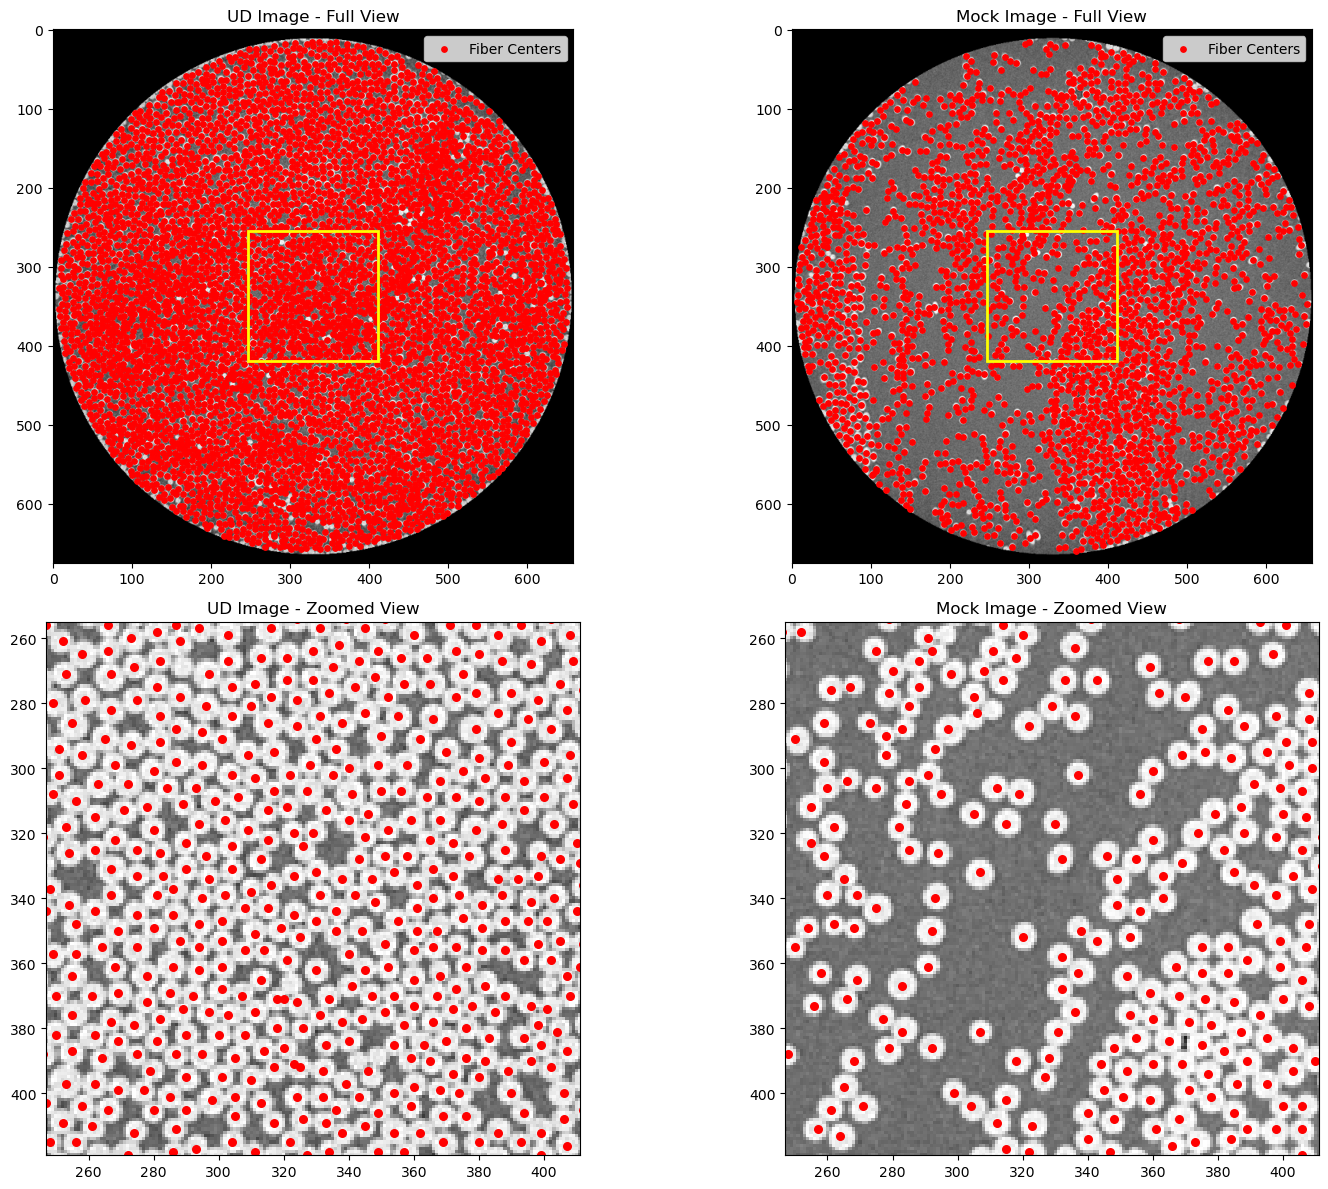

In [7]:
import random

# Thresholds for fiber detection
threshold_UD = 105
threshold_Mock = 130

# Parameters
sigma_UD = 2 # TODO: adjust sigma for UD
sigma_Mock = 2 # TODO: adjust sigma for Mock

index = tif_data_UD.shape[0] // 2#random.randint(0, tif_data_UD.shape[0]) 

# Detect fibers in a single slice
centers_UD, smoothed_UD = detect_fiber_centers(tif_data_UD[index], sigma_UD, threshold_UD)
centers_Mock, smoothed_Mock = detect_fiber_centers(tif_data_Mock[index], sigma_Mock, threshold_Mock)

visualize_fiber_centers_detailed(
    tif_data_UD[index], centers_UD,
    tif_data_Mock[index], centers_Mock
)

In [8]:
# Process the entire volume for both images
fiber_centers_UD = process_volume(tif_data_UD, sigma_UD, threshold_UD)
fiber_centers_Mock = process_volume(tif_data_Mock, sigma_Mock, threshold_Mock)

# for scale = 1.6 it takes on my computer 2 minutes 24 seconds
# for scale = 1.5 it takes on my computer 2 minutes 36 seconds

### Task 2: Track fibers in the z-direction as 3D curves

In [9]:
# track fibers
fib_tracker = track_points_helper.trackpoints()
tracks_UD = fib_tracker(fiber_centers_UD)
tracks_Mock = fib_tracker(fiber_centers_Mock)

# for scale = 1.6 it takes on my computer 5 minutes 16 seconds
# for scale = 1.5 it takes on my computer 5 minutes 43 seconds

Number of original UD tracks: 26362
Number of filtered UD tracks: 8551
Number of original Mock tracks: 8333
Number of filtered Mock tracks: 3652


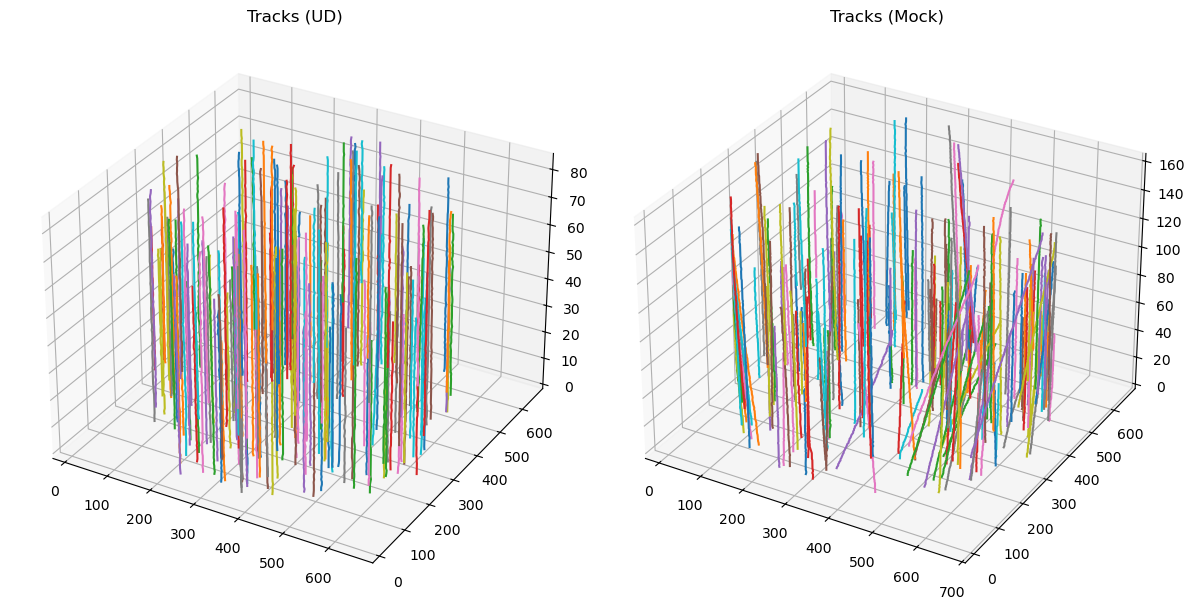

In [19]:
# Filter tracks by minimum length for more reliable orientation measurement
min_track_length = 50 # TODO: Adjust this value
filtered_tracks_UD = [track for track in tracks_UD if (track[-1, 2] - track[0, 2]) > min_track_length]
filtered_tracks_Mock = [track for track in tracks_Mock if (track[-1, 2] - track[0, 2]) > min_track_length]

print(f"Number of original UD tracks: {len(tracks_UD)}")
print(f"Number of filtered UD tracks: {len(filtered_tracks_UD)}")
print(f"Number of original Mock tracks: {len(tracks_Mock)}")
print(f"Number of filtered Mock tracks: {len(filtered_tracks_Mock)}")

# Plot tracks larger than {min_track_length} pixels for both UD and Mock
fig = plt.figure(figsize=(12, 6))

# Plot for tracks_UD
up_count = 0
ud_max_show = 200
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
for track in tracks_UD:
    if (track[-1, 2] - track[0, 2]) > min_track_length:
        up_count += 1
        ax1.plot(track[:, 0], track[:, 1], track[:, 2], '-')
    if up_count > ud_max_show:
        break
ax1.set_title("Tracks (UD)")
ax1.set_aspect('auto')

# Plot for tracks_Mock
mock_count = 0
mock_max_show = 200
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for track in tracks_Mock:
    if (track[-1, 2] - track[0, 2]) > min_track_length:
        mock_count += 1
        ax2.plot(track[:, 0], track[:, 1], track[:, 2], '-')
    if mock_count > mock_max_show:
        break
ax2.set_title("Tracks (Mock)")
ax2.set_aspect('auto')

plt.tight_layout()
plt.show()

##### Further analysis of tracks

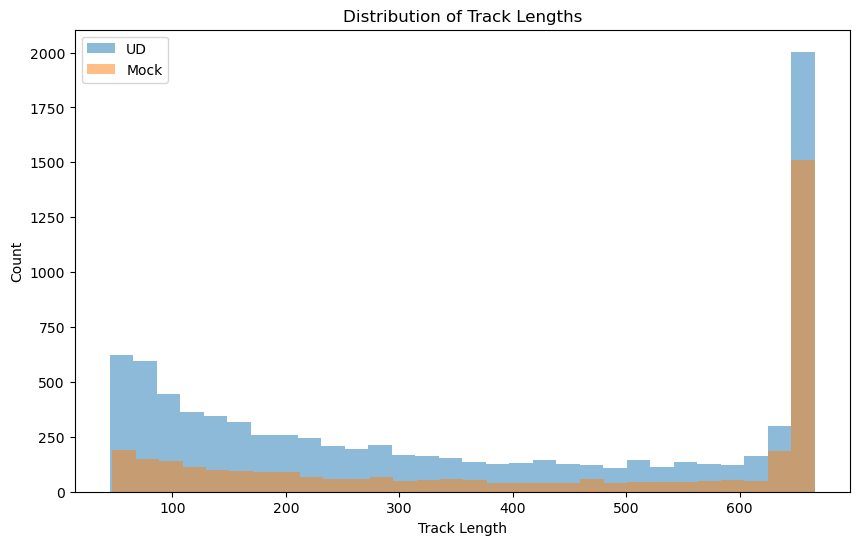

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist([len(t) for t in tracks_UD], bins=30, alpha=0.5, label='UD')
plt.hist([len(t) for t in tracks_Mock], bins=30, alpha=0.5, label='Mock')
plt.xlabel('Track Length')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Track Lengths')
plt.show()

### TASK 3: Measure fiber orientation (azimuth and elevation angles) and make plots

##### Functions

In [12]:
def compute_fiber_orientation(tracks):
    """
    Compute azimuth and elevation angles for each fiber track
    
    Parameters:
    -----------
    tracks : list of np.arrays
        List of fiber tracks, where each track is an array of shape (n_points, 3)
        
    Returns:
    --------
    angles : np.array
        Array of shape (n_tracks, 2) with columns [azimuth, elevation]
    """
    angles = []
    for track in tracks:
            
        # Calculate direction vector (from first to last point)
        direction = track[-1] - track[0]
        
        # Normalize the direction vector
        magnitude = np.linalg.norm(direction)
        if magnitude == 0:
            continue  # Skip if zero displacement
            
        direction = direction / magnitude
        
        # Calculate azimuth angle (in xy-plane, from x-axis)
        # atan2 returns values in [-π, π], we convert to [0, 2π]
        azimuth = np.arctan2(direction[1], direction[0])
        if azimuth < 0:
            azimuth += 2 * np.pi
            
        # Calculate elevation angle (from xy-plane up/down)
        elevation = np.arcsin(direction[2])
        
        angles.append([azimuth, elevation])
        
    return np.array(angles)

def plot_orientation_angles(angles_UD, angles_Mock):
    """Plot orientation angles in different visualizations"""
    # Convert angles from radians to degrees for plotting
    angles_UD_deg = np.degrees(angles_UD)
    angles_Mock_deg = np.degrees(angles_Mock)
    
    # Create a figure with 2 rows and 2 columns
    fig = plt.figure(figsize=(15, 12))
    
    # 1. Azimuth Histogram
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.hist(angles_UD_deg[:, 0], bins=36, range=(0, 360), alpha=0.5, label='UD')
    ax1.hist(angles_Mock_deg[:, 0], bins=36, range=(0, 360), alpha=0.5, label='Mock')
    ax1.set_title('Azimuth Angle Distribution')
    ax1.set_xlabel('Azimuth Angle (degrees)')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    
    # 2. Elevation Histogram
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.hist(angles_UD_deg[:, 1], bins=36, range=(-90, 90), alpha=0.5, label='UD')
    ax2.hist(angles_Mock_deg[:, 1], bins=36, range=(-90, 90), alpha=0.5, label='Mock')
    ax2.set_title('Elevation Angle Distribution')
    ax2.set_xlabel('Elevation Angle (degrees)')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # 3. Polar Scatter Plot for UD
    ax3 = fig.add_subplot(2, 2, 3, projection='polar')
    ax3.scatter(angles_UD[:, 0], np.cos(angles_UD[:, 1]), alpha=0.5, s=10)
    ax3.set_title('UD Orientation (Polar)')
    
    # 4. Polar Scatter Plot for Mock
    ax4 = fig.add_subplot(2, 2, 4, projection='polar')
    ax4.scatter(angles_Mock[:, 0], np.cos(angles_Mock[:, 1]), alpha=0.5, s=10)
    ax4.set_title('Mock Orientation (Polar)')
    
    plt.tight_layout()
    plt.show()
    
    # Create a 3D visualization of fiber orientations using unit vectors
    fig = plt.figure(figsize=(15, 6))
    
    # UD fibers
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    for angle in angles_UD:
        # Convert spherical to Cartesian coordinates (unit vector)
        x = np.cos(angle[1]) * np.cos(angle[0])
        y = np.cos(angle[1]) * np.sin(angle[0])
        z = np.sin(angle[1])
        ax1.quiver(0, 0, 0, x, y, z, length=1, normalize=True, alpha=0.3)
    ax1.set_title('UD Fiber Orientations')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])
    
    # Mock fibers
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    for angle in angles_Mock:
        # Convert spherical to Cartesian coordinates (unit vector)
        x = np.cos(angle[1]) * np.cos(angle[0])
        y = np.cos(angle[1]) * np.sin(angle[0])
        z = np.sin(angle[1])
        ax2.quiver(0, 0, 0, x, y, z, length=1, normalize=True, alpha=0.3)
    ax2.set_title('Mock Fiber Orientations')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    ax2.set_xlim([-1, 1])
    ax2.set_ylim([-1, 1])
    ax2.set_zlim([-1, 1])
    
    plt.tight_layout()
    plt.show()

##### Task results

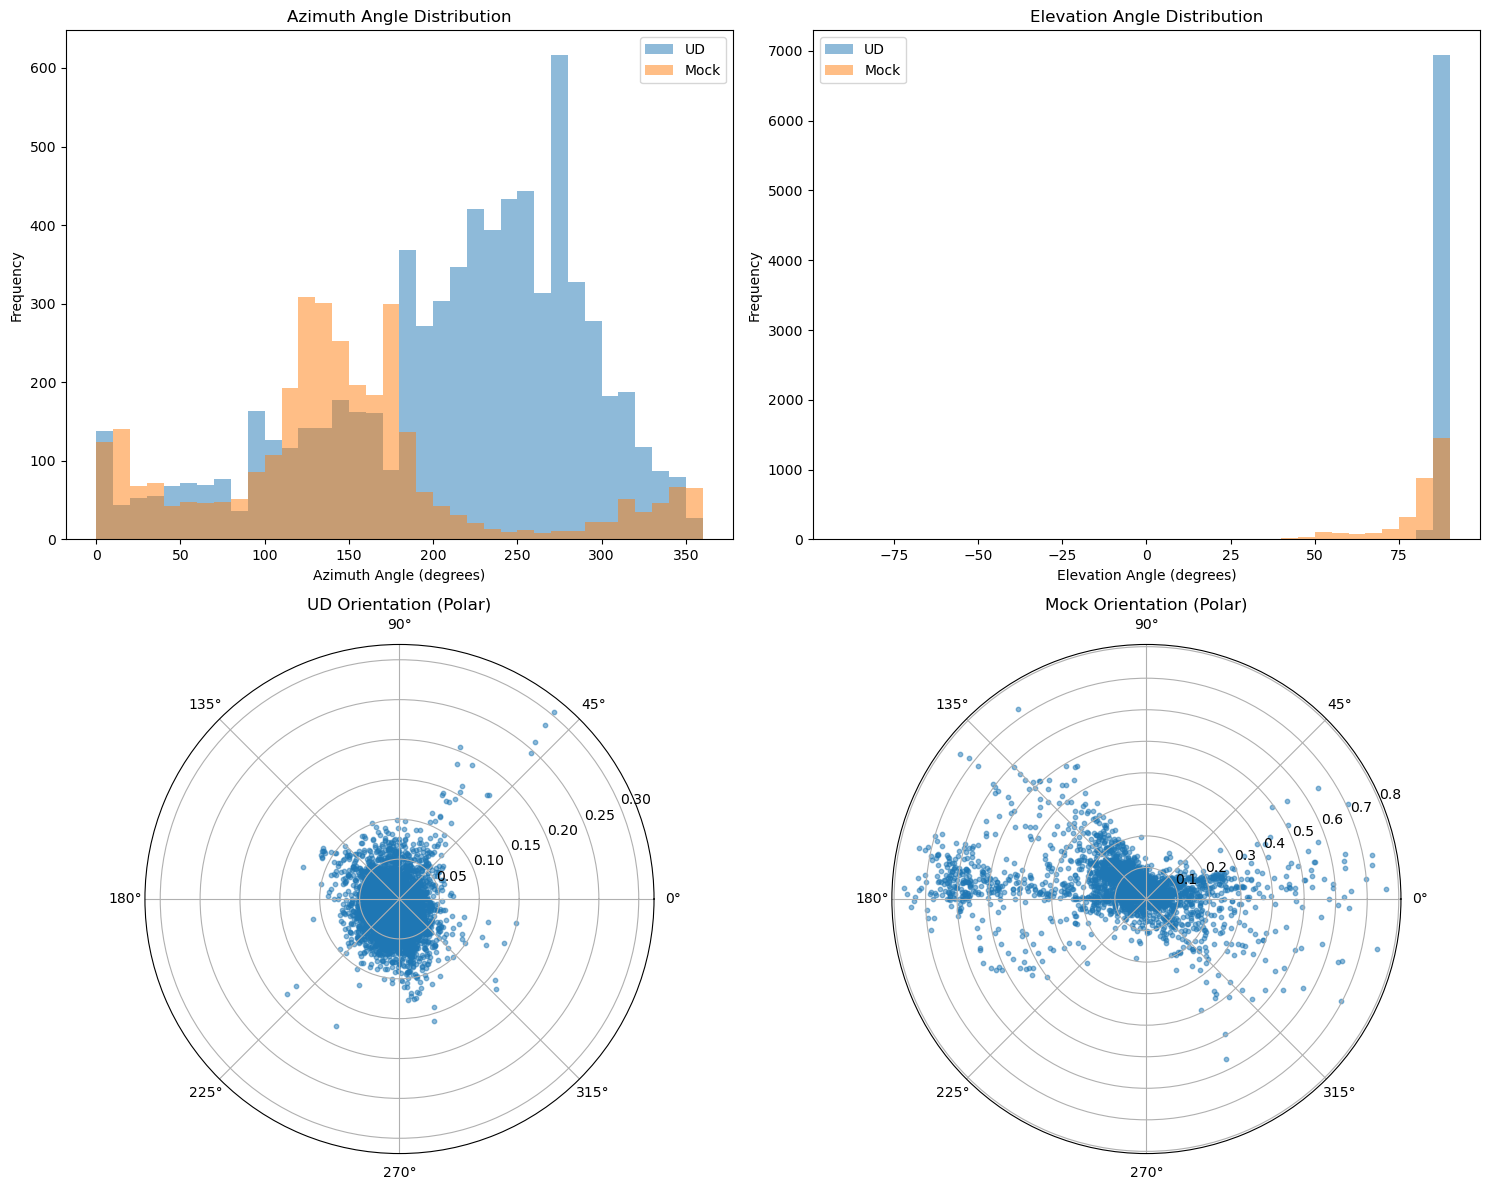

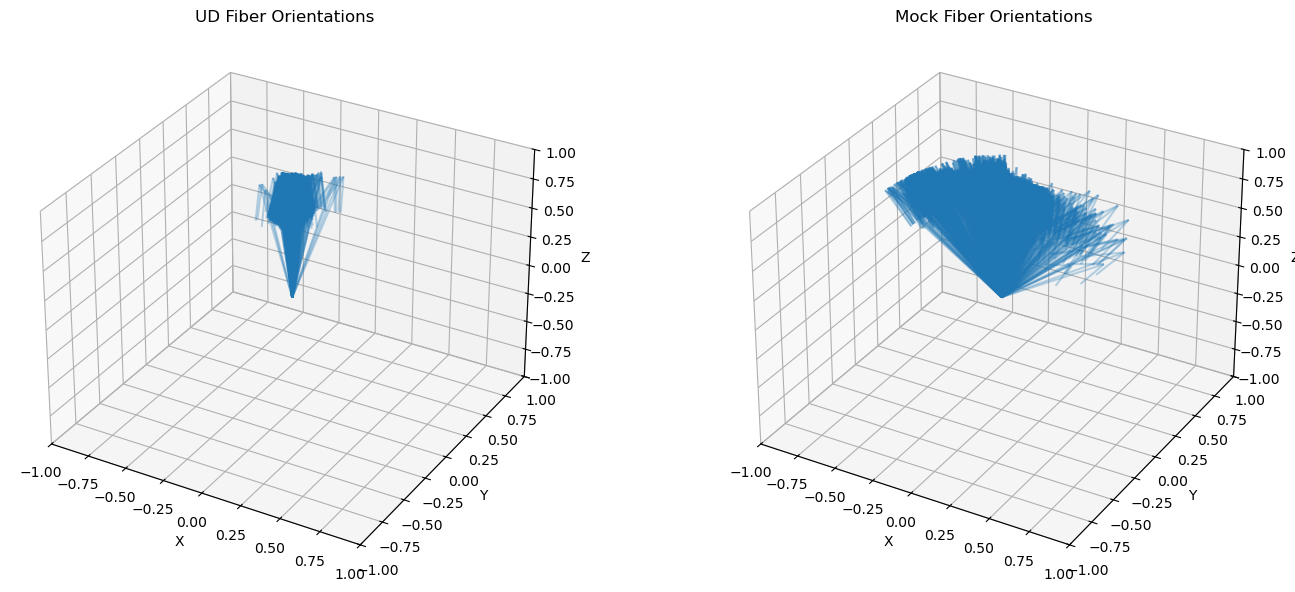


UD fiber orientations (degrees):
Average azimuth: 212.23°
Average elevation: 88.14°

Mock fiber orientations (degrees):
Average azimuth: 145.16°
Average elevation: 80.37°


In [18]:
# Compute orientation angles for UD and Mock fibers
angles_UD = compute_fiber_orientation(filtered_tracks_UD)
angles_Mock = compute_fiber_orientation(filtered_tracks_Mock)

# Plot the orientation angles
plot_orientation_angles(angles_UD, angles_Mock)

# Print summary statistics
print("\nUD fiber orientations (degrees):")
print(f"Average azimuth: {np.degrees(np.mean(angles_UD[:, 0])):.2f}°")
print(f"Average elevation: {np.degrees(np.mean(angles_UD[:, 1])):.2f}°")

print("\nMock fiber orientations (degrees):")
print(f"Average azimuth: {np.degrees(np.mean(angles_Mock[:, 0])):.2f}°")
print(f"Average elevation: {np.degrees(np.mean(angles_Mock[:, 1])):.2f}°")

##### Description
* Azimuth angle: Represents the angle in the xy-plane (0° to 360°)
    - 0° = positive x-axis direction
    - 90° = positive y-axis direction
    - 180° = negative x-axis direction
    - 270° = negative y-axis direction

* Elevation angle: Represents the angle from the xy-plane (-90° to 90°)
    - 0° = fiber lies flat in the xy-plane
    - 90° = fiber points straight up (positive z-axis)
    - -90° = fiber points straight down (negative z-axis)

##### Analysis
* min_track_length = 50
    - UD fibers show a very high elevation angle (with an average of 88°) which underlines the fact, that most of the fibers are aligned horizontally.
    - The azimuth angle for UD fibers is not as relevant since they are very much aligned with the z-axis. Nevertheless, we can see that the azimuth angle is more or less evenly distributed with an average of 208.82° and local maxima at 0°, 90°, 180° and 270°.
    - Mock fibers show a more random distribution of elevation angles indicating they are not as perfectly aligned with the z-axis. The average elevation angle is 79.4°.
    - The azimuth angle is more relevant for mock fibers since they are less aligned with the z-axis. The azimuth angle has its peek around 146° and furthermore, the majority of the azimuth angles are between 90° and 180° as we can also observe in the bottom right plot.
* min_track_length = 100
    - pretty much the same, only average elevation angle is a little higher for Mock fibers than before (now 80.1°)

### Task 4: Measure fiber curvature and make plots

##### Functions

In [24]:
def compute_parametric_curvature(tracks):
    """
    Compute curvature for 3D tracks using the parametric curvature formula
    
    Parameters:
    -----------
    tracks : list of np.arrays
        List of fiber tracks, where each track is an array of shape (n_points, 3)
        
    Returns:
    --------
    track_curvatures : list
        List of arrays containing curvature values along each track
    """
    track_curvatures = []
    track_lengths = []
    
    for track in tracks:
        n_points = len(track)
        if n_points < 3:
            track_curvatures.append(np.array([]))
            continue
            
        curvatures = np.zeros(n_points)
        
        # Compute first derivatives using central differences
        velocity = np.zeros_like(track)
        velocity[1:-1] = (track[2:] - track[:-2]) / 2.0
        velocity[0] = track[1] - track[0] / 2.0
        velocity[-1] = track[-1] - track[-2] / 2.0
        
        # Compute second derivatives using central differences
        acceleration = np.zeros_like(track)
        acceleration[1:-1] = (track[2:] - 2*track[1:-1] + track[:-2])
        acceleration[0] = track[2] - 2*track[1] + track[0]
        acceleration[-1] = track[-1] - 2*track[-2] + track[-3]
        
        # Calculate curvature for each point using the formula:
        # κ = |r' × r''| / |r'|³
        for i in range(n_points):
            v = velocity[i]      # First derivative
            a = acceleration[i]  # Second derivative
            
            # Calculate cross product |r' × r''|
            cross_product = np.cross(v, a)
            numerator = np.linalg.norm(cross_product)
            
            # Calculate |r'|³
            v_magnitude = np.linalg.norm(v)
            denominator = v_magnitude**3
            
            # Calculate curvature (avoid division by zero)
            if denominator > 1e-10:
                curvatures[i] = numerator / denominator
        
        track_curvatures.append(curvatures)
        track_lengths.append(n_points)
    
    return track_curvatures, track_lengths

# Function to compute average curvature per track
def compute_average_parametric_curvature(tracks):
    """
    Compute average parametric curvature for each track
    """
    avg_curvatures = []
    
    track_curvatures, track_lengths = compute_parametric_curvature(tracks)
    for curvatures in track_curvatures:
        valid_curvatures = curvatures[(curvatures > 0) & np.isfinite(curvatures) & (curvatures < 1e6)]
        if len(valid_curvatures) > 0:
            avg_curvatures.append(np.mean(valid_curvatures))
    
    return np.array(avg_curvatures), np.array(track_lengths)

# Function to plot histograms of curvature
def plot_curvature_histogram(curvatures_UD, curvatures_Mock):
    """
    Plot histograms of fiber curvatures
    
    Parameters:
    -----------
    curvatures_UD : np.array
        Array of curvature values for UD fibers
    curvatures_Mock : np.array
        Array of curvature values for Mock fibers
    """
    plt.figure(figsize=(12, 6))
    
    # Define bins based on the range of curvatures
    max_curvature = max(np.percentile(curvatures_UD, 99), np.percentile(curvatures_Mock, 99))
    bins = np.linspace(0, max_curvature, 50)
    
    plt.hist(curvatures_UD, bins=bins, alpha=0.5, label='UD')
    plt.hist(curvatures_Mock, bins=bins, alpha=0.5, label='Mock')
    
    plt.title('Fiber Curvature Distribution')
    plt.xlabel('Curvature')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("UD fiber curvatures:")
    print(f"  Mean: {np.mean(curvatures_UD):.6f}")
    print(f"  Median: {np.median(curvatures_UD):.6f}")
    print(f"  Min: {np.min(curvatures_UD):.6f}")
    print(f"  Max: {np.max(curvatures_UD):.6f}")
    
    print("\nMock fiber curvatures:")
    print(f"  Mean: {np.mean(curvatures_Mock):.6f}")
    print(f"  Median: {np.median(curvatures_Mock):.6f}")
    print(f"  Min: {np.min(curvatures_Mock):.6f}")
    print(f"  Max: {np.max(curvatures_Mock):.6f}")

##### Task results

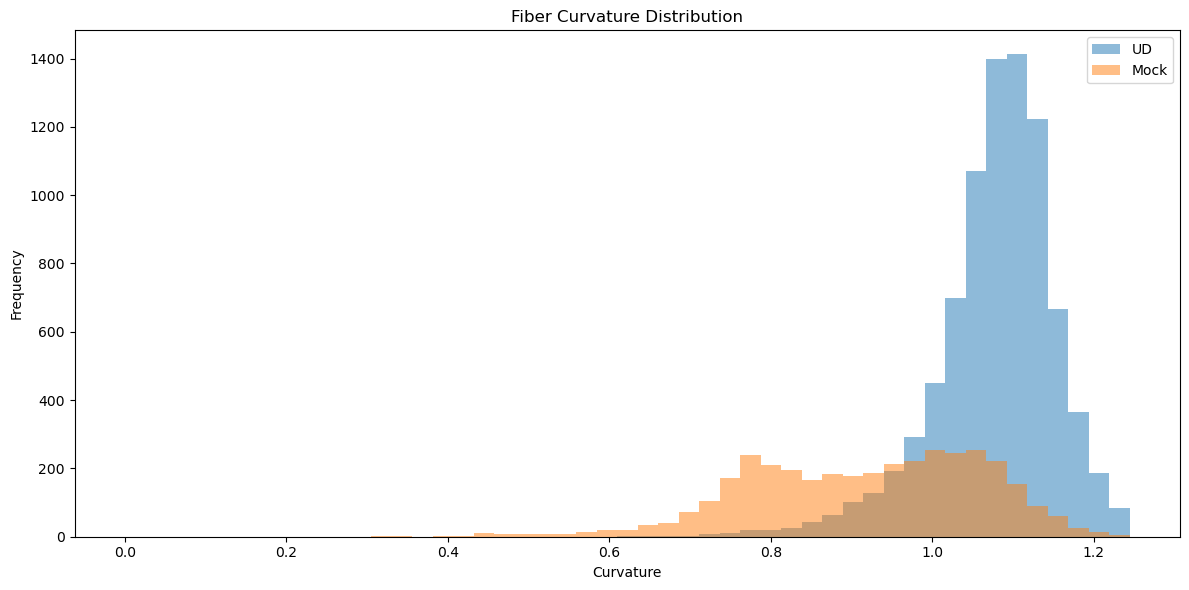

UD fiber curvatures:
  Mean: 1.079682
  Median: 1.087533
  Min: 0.623886
  Max: 1.534052

Mock fiber curvatures:
  Mean: 0.917469
  Median: 0.933381
  Min: 0.314617
  Max: 1.363129


In [25]:
# Plot histograms of curvature
parametric_curvatures_UD, track_lengths_UD = compute_average_parametric_curvature(filtered_tracks_UD)
parametric_curvatures_Mock, track_lengths_Mock = compute_average_parametric_curvature(filtered_tracks_Mock)
plot_curvature_histogram(parametric_curvatures_UD, parametric_curvatures_Mock)

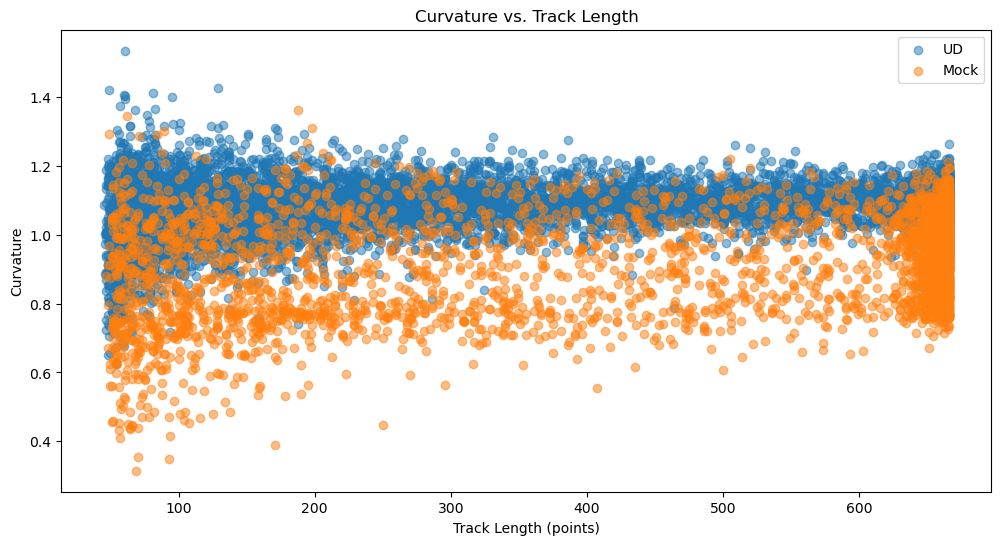

In [26]:
# Plot curvature vs track length
plt.figure(figsize=(12, 6))
plt.scatter(track_lengths_UD, parametric_curvatures_UD, alpha=0.5, label='UD')
plt.scatter(track_lengths_Mock, parametric_curvatures_Mock, alpha=0.5, label='Mock')
plt.xlabel('Track Length (points)')
plt.ylabel('Curvature')
plt.legend()
plt.title('Curvature vs. Track Length')
plt.show()

##### Analysis
* The curvature of UD fibers ranges from 0.8 to 1.4 for tracks with small lengths and then gets more and more constant around 1.1.
* The curvature of mock fibers ranges a lot more. To be specific it ranges from 0.4 to 1.4 for short tracks and gets a little closer until the maximum length (1000) where it ranges from 0.8 to 1.2.